## The Process
### 1. visualize the data
### 2. stationarize the time series
### 3. plot ACF/PACF
### 4. build the ARIMA
### 5. make the prediction

### reference: http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [4]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 500]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]


# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3618, 500)  train1 y: (3618, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
validation1 X: (400, 500)  validation1 y: (400, 1)
train2 X: (3293, 500)  train2 y: (3293, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)
validation2 X: (360, 500)  validation2 y: (360, 1)


## First use the last 365 days as test set

In [17]:
from statsmodels.tsa.stattools import adfuller
df = y.copy()
df['y']=y.values
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=30,center=False).mean()
    rolstd = timeseries.rolling(window=30,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

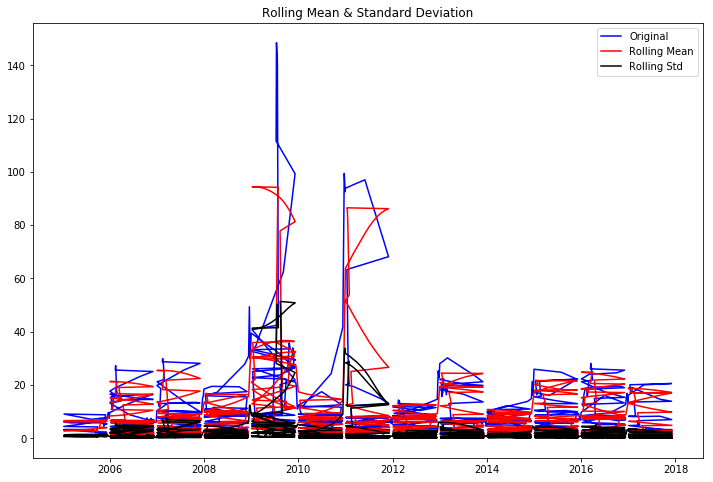

Results of Dickey-Fuller Test:
Test Statistic                -7.356968e+00
p-value                        9.722981e-11
#Lags Used                     3.100000e+01
Number of Observations Used    4.351000e+03
Critical Value (1%)           -3.431854e+00
Critical Value (5%)           -2.862205e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


In [18]:
test_stationarity(df.y)

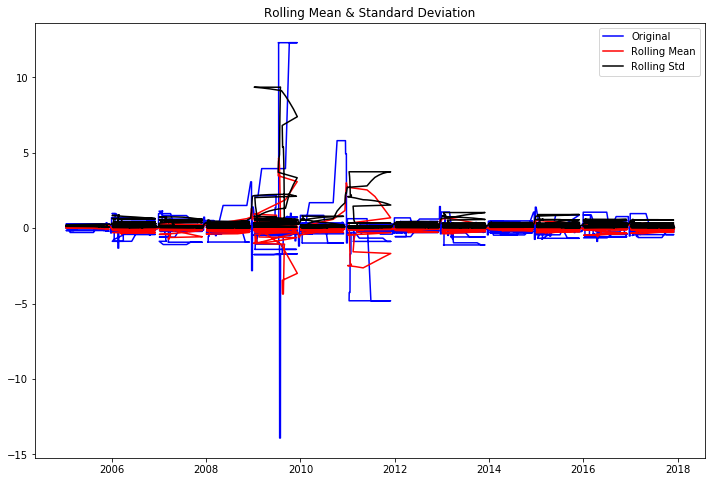

Results of Dickey-Fuller Test:
Test Statistic                -1.294262e+01
p-value                        3.508763e-24
#Lags Used                     3.100000e+01
Number of Observations Used    4.350000e+03
Critical Value (1%)           -3.431854e+00
Critical Value (5%)           -2.862205e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


In [19]:
# take a first difference of the data, remove the overall trend
df['first_dif'] = df.y-df.y.shift(1)
test_stationarity(df.first_dif.dropna(inplace=False))

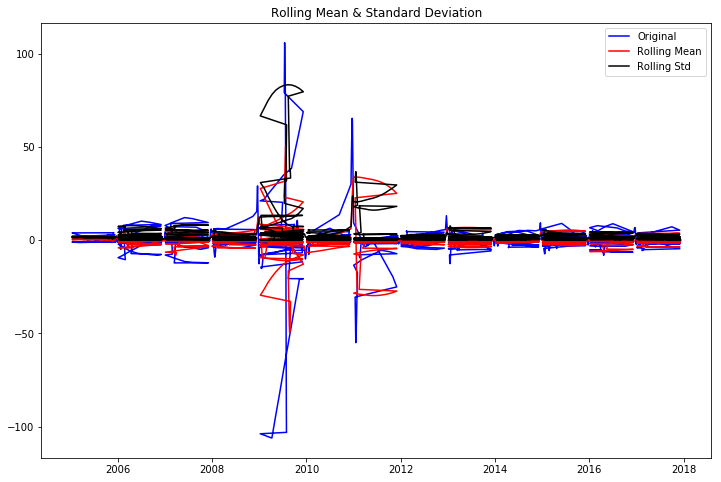

Results of Dickey-Fuller Test:
Test Statistic                -1.161143e+01
p-value                        2.507599e-21
#Lags Used                     3.100000e+01
Number of Observations Used    4.339000e+03
Critical Value (1%)           -3.431858e+00
Critical Value (5%)           -2.862206e+00
Critical Value (10%)          -2.567125e+00
dtype: float64


In [20]:
# remove the seasonality
df['seasonal_dif'] = df.y-df.y.shift(12)
test_stationarity(df.seasonal_dif.dropna(inplace=False))

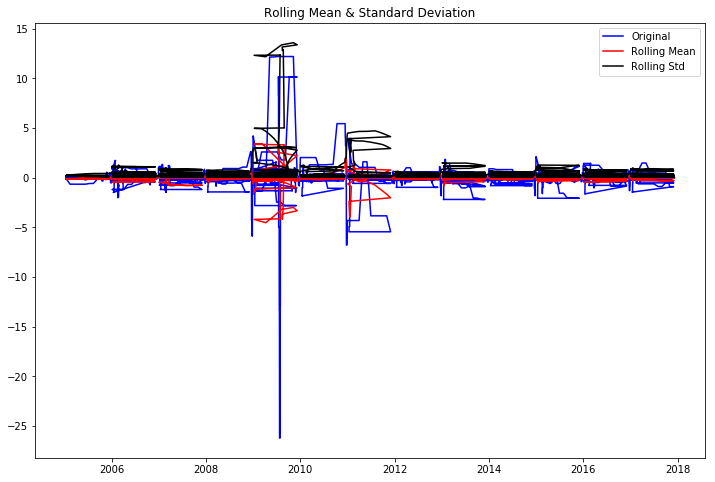

Results of Dickey-Fuller Test:
Test Statistic                -1.765380e+01
p-value                        3.709482e-30
#Lags Used                     3.000000e+01
Number of Observations Used    4.339000e+03
Critical Value (1%)           -3.431858e+00
Critical Value (5%)           -2.862206e+00
Critical Value (10%)          -2.567125e+00
dtype: float64


In [21]:
# take a first difference of seasonal difference
df['seasonal_first_dif'] = df.first_dif - df.first_dif.shift(12)
test_stationarity(df.seasonal_first_dif.dropna(inplace=False))

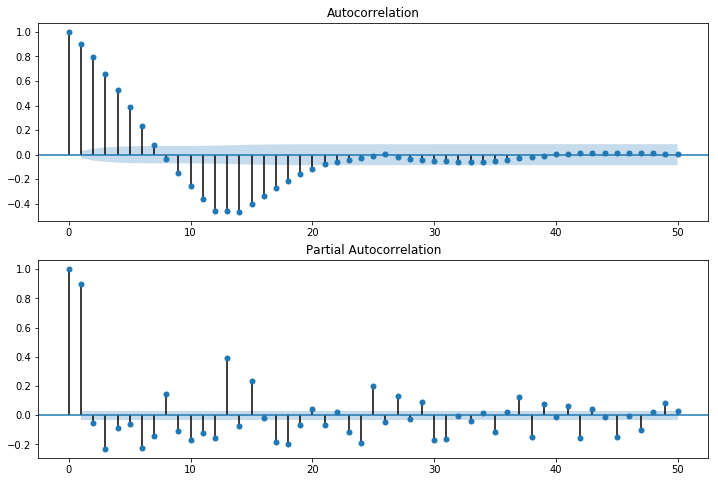

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_dif.iloc[13:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_dif.iloc[13:], lags=50, ax=ax2)

In [13]:
# the 3 queries 
df3 = train1_X2.iloc[:, 0: 3].copy()
df4 = test1_X.iloc[:,0:3].copy()


In [14]:
p_values = [0,1]
d_values = [1,2]
q_values = [13,14]
P_v=[0,1]
D_v=[0,1]
Q_v=[0,1]
s_v=[0,7,12]
train_X=df3
test_X=df4
best_score=1000000000
p0=0
d0=0
q0=0
P0=0
D0=0
Q0=0
s0=0
param_best=list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_v:
                for D in D_v:
                    for Q in Q_v:
                        for s in s_v:
                            try:
                                model = sm.tsa.statespace.SARIMAX(endog =train1_y2.values,
                                                                  exog=train_X,
                                                                  trend='n', order=(p,d,q),
                                                                  seasonal_order=(P,D,Q,s),
                                                                  enforce_stationarity=False,
                                                                  enforce_invertibility=False)
                                model_fit = model.fit()
                                aic = model_fit.aic
                                print('(',p,',',d,',',q,'),(',P,',',D,',',Q,',',s,') AIC:',aic)
                                
                                if aic < best_score:
                                    best_score = aic
                                    param_best = model_fit().params
                                    p0=p
                                    d0=d
                                    q0=q
                                    P0=P
                                    D0=D
                                    Q0=Q
                                    s0=s
                                
                            except:
                                continue
print('Best SARIMA (',p0,',',d0,',',q0,'),(',P0,',',D0,',',Q0,',',s0,') AIC:', best_score)
print(param_best)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 0 , 0 ) AIC: 4049.936667301583


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 0 , 7 ) AIC: 4049.936667301583


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 0 , 12 ) AIC: 4049.936667301583


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 0 , 0 , 1 , 0 ) AIC: 5930.060845632885


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 1 , 7 ) AIC: 4379.669166103715


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 0 , 0 , 1 , 12 ) AIC: 4616.665815384689


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 0 , 1 , 0 , 7 ) AIC: 6266.52422495958


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 0 , 1 , 0 , 12 ) AIC: 7606.224873741564


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 0 , 1 , 1 , 7 ) AIC: 5683.509223560736


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 0 , 1 , 1 , 12 ) AIC: 6726.616772879761


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 1 , 0 , 0 , 0 ) AIC: 6078.9398698093555


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 1 , 0 , 0 , 7 ) AIC: 4383.175515849488


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 1 , 0 , 0 , 12 ) AIC: 4615.360918909719


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 1 , 0 , 1 , 0 ) AIC: 5435.686616337505


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 1 , 0 , 1 , 7 ) AIC: 4274.370945731536


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 1 , 0 , 1 , 12 ) AIC: 4620.950824014963


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 1 , 0 , 7 ) AIC: 5338.521017566549


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 1 , 1 , 0 , 12 ) AIC: 6706.7015175665965


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 1 , 1 , 7 ) AIC: 5345.41442123786


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ),( 1 , 1 , 1 , 12 ) AIC: 8518.901009332512


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 0 , 0 , 0 , 0 ) AIC: 4530.022607385947


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 0 , 0 , 0 , 7 ) AIC: 4530.022607385947


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 0 , 0 , 0 , 12 ) AIC: 4530.022607385947


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 0 , 1 , 0 ) AIC: 4710.115572752973


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 0 , 0 , 1 , 7 ) AIC: 4453.463417826533


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 0 , 0 , 1 , 12 ) AIC: 4085.3716460353967


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 0 , 1 , 0 , 7 ) AIC: 7102.7282486068325


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 1 , 0 , 12 ) AIC: 6626.180520225468


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 0 , 1 , 1 , 7 ) AIC: 6873.4493780585


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 1 , 1 , 12 ) AIC: 5822.456404265395


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 0 , 0 ) AIC: 6110.2367865780925


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 1 , 0 , 0 , 7 ) AIC: 4926.803322779242


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 1 , 0 , 0 , 12 ) AIC: 4106.276743425063


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 1 , 0 , 1 , 0 ) AIC: 6179.750266481433


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 4420.377941683559


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 1 , 12 ) AIC: 4084.9861231586183


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 1 , 1 , 0 , 7 ) AIC: 6995.807562975044


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 1 , 0 , 12 ) AIC: 6400.330011450356


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 1 , 1 , 1 , 7 ) AIC: 6947.984668041585


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 14 ),( 1 , 1 , 1 , 12 ) AIC: 6174.334708999948


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 0 , 0 , 0 , 0 ) AIC: 4429.4200936204115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 0 , 0 , 0 , 7 ) AIC: 4429.4200936204115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 0 , 0 , 0 , 12 ) AIC: 4429.4200936204115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 0 , 0 , 1 , 0 ) AIC: 4431.818683173394


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 0 , 0 , 1 , 7 ) AIC: 4479.977800624981


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 0 , 0 , 1 , 12 ) AIC: 4435.064469372081


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 0 , 1 , 0 , 7 ) AIC: 5263.974098257878


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 13 ),( 0 , 1 , 0 , 12 ) AIC: 5652.92214360332


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 0 , 1 , 1 , 7 ) AIC: 4523.883689622318


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 13 ),( 0 , 1 , 1 , 12 ) AIC: 5931.348876076582


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 0 , 0 , 0 ) AIC: 4431.958515130926


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 13 ),( 1 , 0 , 0 , 7 ) AIC: 4453.884515696154


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 0 , 0 , 12 ) AIC: 4434.482949951081


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 0 , 1 , 0 ) AIC: 4433.820613989528


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 0 , 1 , 7 ) AIC: 3751.9643564184144


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 0 , 1 , 12 ) AIC: 4437.266479426518


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 1 , 0 , 7 ) AIC: 5185.795580296638


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 1 , 0 , 12 ) AIC: 6202.149139786363


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 1 , 1 , 7 ) AIC: 4419.766890024339


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ),( 1 , 1 , 1 , 12 ) AIC: 6042.403200716231


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 0 , 0 , 0 , 0 ) AIC: 3545.5745378754473


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 0 , 0 , 0 , 7 ) AIC: 3545.5745378754473


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 0 , 0 , 0 , 12 ) AIC: 3545.5745378754473


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 0 , 0 , 1 , 0 ) AIC: 3442.11119240007


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 0 , 0 , 1 , 7 ) AIC: 3551.0928787942885


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 0 , 0 , 1 , 12 ) AIC: 3464.122404267203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 0 , 1 , 0 , 7 ) AIC: 6044.1078573995765


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 0 , 1 , 0 , 12 ) AIC: 5853.548806181783


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 0 , 1 , 1 , 7 ) AIC: 4085.1419511115737


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 0 , 1 , 1 , 12 ) AIC: 5986.4804366575545


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 1 , 0 , 0 , 0 ) AIC: 3442.6126623406512


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 1 , 0 , 0 , 7 ) AIC: 3527.1968113045036


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 1 , 0 , 0 , 12 ) AIC: 3435.835509302441


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 1 , 0 , 1 , 0 ) AIC: 3445.3121678792904


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 3447.37945840057


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 1 , 0 , 1 , 12 ) AIC: 3462.354250983144


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 1 , 1 , 0 , 7 ) AIC: 5808.1620296039955


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 14 ),( 1 , 1 , 0 , 12 ) AIC: 6242.731575355721


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 1 , 1 , 7 ) AIC: 3924.383767191532


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 1 , 1 , 12 ) AIC: 6384.075243554542


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 0 , 0 , 0 , 0 ) AIC: 4493.456889113037


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 0 , 0 , 0 , 7 ) AIC: 4493.456889113037


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 0 , 0 , 0 , 12 ) AIC: 4493.456889113037


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 0 , 1 , 0 ) AIC: 5776.121183414044


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 0 , 0 , 1 , 7 ) AIC: 4282.016623195106


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 0 , 0 , 1 , 12 ) AIC: 4495.760003226495


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 0 , 1 , 0 , 7 ) AIC: 5418.559227314313


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 1 , 0 , 12 ) AIC: 5458.562723928158


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 0 , 1 , 1 , 7 ) AIC: 5102.017556139324


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 0 , 1 , 1 , 12 ) AIC: 5209.1146287387255


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 1 , 0 , 0 , 0 ) AIC: 6778.879582868184


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 0 , 0 , 7 ) AIC: 4342.367358675947


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 1 , 0 , 0 , 12 ) AIC: 4503.771225216656


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 0 , 1 , 0 ) AIC: 5555.0822339269


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 1 , 0 , 1 , 7 ) AIC: 4251.659796770437


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 1 , 0 , 1 , 12 ) AIC: 4493.642172553839


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 1 , 1 , 0 , 7 ) AIC: 5298.370526791534


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 1 , 1 , 0 , 12 ) AIC: 5590.8078381163705


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 1 , 1 , 1 , 7 ) AIC: 5237.067086491149


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ),( 1 , 1 , 1 , 12 ) AIC: 5303.781084741534


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 0 , 0 , 0 , 0 ) AIC: 4099.166393826734


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 0 , 0 , 0 , 7 ) AIC: 4099.166393826734


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 0 , 0 , 0 , 12 ) AIC: 4099.166393826734


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 0 , 0 , 1 , 0 ) AIC: 5471.652512609649


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 0 , 0 , 1 , 7 ) AIC: 3694.1694541950847


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 0 , 0 , 1 , 12 ) AIC: 4092.9505082763894


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 0 , 1 , 0 , 7 ) AIC: 5236.688985895698


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 0 , 1 , 0 , 12 ) AIC: 5979.1365580726515


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 0 , 1 , 1 , 7 ) AIC: 5419.607847262988


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 0 , 1 , 1 , 12 ) AIC: 5746.065036381114


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 1 , 0 , 0 , 0 ) AIC: 5514.459398759218


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 1 , 0 , 0 , 7 ) AIC: 4219.582425585206


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 1 , 0 , 0 , 12 ) AIC: 4111.5152160195175


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 1 , 0 , 1 , 0 ) AIC: 5148.642302360869


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 4318.185774579596


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 1 , 0 , 1 , 12 ) AIC: 3694.959285782892


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 1 , 1 , 0 , 7 ) AIC: 5618.409901031524


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 1 , 0 , 12 ) AIC: 5747.395342249457


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ),( 1 , 1 , 1 , 7 ) AIC: 5524.622943647253


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 1 , 1 , 12 ) AIC: 5858.030068280086


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 0 , 0 , 0 ) AIC: 4430.802285678875


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 0 , 0 , 7 ) AIC: 4430.802285678875


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 0 , 0 , 12 ) AIC: 4430.802285678875


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 0 , 1 , 0 ) AIC: 4433.222277865535


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 0 , 1 , 7 ) AIC: 4481.812462897882


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 0 , 1 , 12 ) AIC: 4436.429053904436


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 1 , 0 , 7 ) AIC: 5265.961536103602


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 1 , 0 , 12 ) AIC: 5768.768325845419


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 0 , 1 , 1 , 7 ) AIC: 4525.860294794398


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 0 , 1 , 1 , 12 ) AIC: 5980.505051345848


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 1 , 0 , 0 , 0 ) AIC: 4433.385785251251


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 1 , 0 , 0 , 7 ) AIC: 4455.048301980355


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 1 , 0 , 0 , 12 ) AIC: 4435.890751782185


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 1 , 0 , 1 , 0 ) AIC: 4435.224160299553


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 1 , 0 , 1 , 7 ) AIC: 3769.41610283496


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 1 , 0 , 1 , 12 ) AIC: 4438.630590463898


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 1 , 1 , 0 , 7 ) AIC: 5187.778158694286


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 1 , 1 , 0 , 12 ) AIC: 6205.522551688744


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ),( 1 , 1 , 1 , 7 ) AIC: 4421.6669682763795


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 1 , 1 , 1 , 12 ) AIC: 5749.312162593275


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 0 , 0 , 0 ) AIC: 3550.74956784021


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 0 , 0 , 7 ) AIC: 3550.74956784021


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 0 , 0 , 12 ) AIC: 3550.74956784021


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 0 , 0 , 1 , 0 ) AIC: 3550.1025604305746


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 0 , 1 , 7 ) AIC: 3552.998511397171


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 0 , 1 , 12 ) AIC: 3431.964793251319


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 1 , 0 , 7 ) AIC: 6045.976976241528


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 1 , 0 , 12 ) AIC: 5875.540598593351


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 1 , 1 , 7 ) AIC: 4084.01099021467


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 0 , 1 , 1 , 12 ) AIC: 6012.542434764624


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 0 , 0 , 0 ) AIC: 3550.0862842786382


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 0 , 0 , 7 ) AIC: 3529.1093900155383


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 0 , 0 , 12 ) AIC: 3552.9008563248535


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 0 , 1 , 0 ) AIC: 3552.0651105859706


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 3449.3076721361654


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 0 , 1 , 12 ) AIC: 3432.896525945602


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 1 , 0 , 7 ) AIC: 5810.0615719988


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 1 , 0 , 12 ) AIC: 6277.611350194521


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 1 , 1 , 7 ) AIC: 3918.317365175065


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ),( 1 , 1 , 1 , 12 ) AIC: 6418.576574157205
Best SARIMA ( 0 , 0 , 0 ),( 0 , 0 , 0 , 0 ) AIC: 3431.964793251319
[]


### above did not print the correct final result, but I come back and find for AIC=3431.96 is (1,2,14)(0,0,1,12)

In [13]:
## first try without seasonal term, it is faster
p_values = [1,2,3]
d_values = [1,2,3]
q_values = [13,14,15]


train_X = train1_X2.iloc[:, 0: 3].copy()
test_X = test1_X.iloc[:,0:3].copy()


best_score=1000000000
p0=0
d0=0
q0=0

param=list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = sm.tsa.statespace.SARIMAX(endog =train1_y2.values,
                                                  exog=train_X,
                                                  trend='n', order=(p,d,q),

                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                model_fit = model.fit()
                aic = model_fit.aic
                print('(',p,',',d,',',q,'), AIC:',aic)
                if (aic < best_score):
                    best_score = aic
                    param = model_fit().params
                    p0=p
                    d0=d
                    q0=q
            except:
                continue
print('Best SARIMA (',p0,',',d0,',',q0,'), AIC:', best_score)
print(param)


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ), AIC: 4493.456889113037


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 14 ), AIC: 4099.166393826734


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 15 ), AIC: 4104.057430812287


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 13 ), AIC: 4430.802285678875


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 14 ), AIC: 3550.74956784021


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 15 ), AIC: 3431.5878915480216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 3 , 13 ), AIC: 4708.874778859626


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 3 , 14 ), AIC: 4683.5981023678005


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 3 , 15 ), AIC: 3887.3565498830103


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 1 , 13 ), AIC: 4462.575401394584


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 1 , 14 ), AIC: 4102.215509998072


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 1 , 15 ), AIC: 4102.208609300833


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 2 , 13 ), AIC: 4425.627732540665


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 2 , 14 ), AIC: 3554.7171492601683


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 2 , 15 ), AIC: 3553.9996567824537


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 3 , 13 ), AIC: 4590.82544596098


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 3 , 14 ), AIC: 4508.887785209855


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 3 , 15 ), AIC: 4062.3382771369334


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 3 , 1 , 13 ), AIC: 4331.279492823772


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 3 , 1 , 14 ), AIC: 4102.298469941792


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 3 , 1 , 15 ), AIC: 4289.593715183839


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 3 , 2 , 13 ), AIC: 4417.996149940799


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 3 , 2 , 14 ), AIC: 3557.0764678093765


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 3 , 2 , 15 ), AIC: 3556.0230917718295


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 3 , 3 , 13 ), AIC: 4574.977669201416


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 3 , 3 , 14 ), AIC: 4291.739272492246


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 3 , 3 , 15 ), AIC: 3881.810616392258
Best SARIMA ( 0 , 0 , 0 ), AIC: 3431.5878915480216
[]


In [12]:
## the above (1,2,15) gives best for X= 3 columns, AIC=3431.59
p_values = [1]
d_values = [2]
q_values = [15]
P_v=[0,1]
D_v=[0,1]
Q_v=[0,1]
s_v=[0,7,12]
train_X=df3
test_X=df4
best_score=1000000000
p0=0
d0=0
q0=0
P0=0
D0=0
Q0=0
s0=0
param_best=list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_v:
                for D in D_v:
                    for Q in Q_v:
                        for s in s_v:
                            try:
                                model = sm.tsa.statespace.SARIMAX(endog =train1_y2.values,
                                                                  exog=train_X,
                                                                  trend='n', order=(p,d,q),
                                                                  seasonal_order=(P,D,Q,s),
                                                                  enforce_stationarity=False,
                                                                  enforce_invertibility=False)
                                model_fit = model.fit()
                                aic = model_fit.aic
                                print('(',p,',',d,',',q,'),(',P,',',D,',',Q,',',s,') AIC:',aic)
                                
                                if aic < best_score:
                                    best_score = aic
                                    param_best = model_fit().params
                                    p0=p
                                    d0=d
                                    q0=q
                                    P0=P
                                    D0=D
                                    Q0=Q
                                    s0=s
                                
                            except:
                                continue
print('Best SARIMA (',p0,',',d0,',',q0,'),(',P0,',',D0,',',Q0,',',s0,') AIC:', best_score)
print(param_best)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 15 ),( 0 , 0 , 0 , 0 ) AIC: 3431.5878915480216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 15 ),( 0 , 0 , 0 , 7 ) AIC: 3431.5878915480216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 15 ),( 0 , 0 , 0 , 12 ) AIC: 3431.5878915480216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 0 , 0 , 1 , 0 ) AIC: 3552.903356610051


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 0 , 0 , 1 , 7 ) AIC: 3553.2818095312027


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 0 , 0 , 1 , 12 ) AIC: 3557.371763298016


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 0 , 1 , 0 , 7 ) AIC: 6046.253019286218


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 15 ),( 0 , 1 , 0 , 12 ) AIC: 6160.082309919112


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 0 , 1 , 1 , 7 ) AIC: 4126.061238939082


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 0 , 1 , 1 , 12 ) AIC: 6519.069722745369


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 0 , 0 , 0 ) AIC: 3552.9109429172418


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 0 , 0 , 7 ) AIC: 3528.9950094123096


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 0 , 0 , 12 ) AIC: 3553.4864377938843


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 0 , 1 , 0 ) AIC: 3554.915158782993


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 0 , 1 , 7 ) AIC: 3450.097748643014


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 0 , 1 , 12 ) AIC: 3559.502046930978


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 1 , 0 , 7 ) AIC: 5811.0878928408365


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 1 , 0 , 12 ) AIC: 6826.455615484582


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 1 , 1 , 7 ) AIC: 3937.2904922045786


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ),( 1 , 1 , 1 , 12 ) AIC: 7058.141379082339
Best SARIMA ( 0 , 0 , 0 ),( 0 , 0 , 0 , 0 ) AIC: 3431.5878915480216
[]


In [12]:
## X with first 20 queries
## first try without seasonal term, it is faster
p_values = [0,1,2]
d_values = [0,1,2]
q_values = [5,7,9,11,13,15]


train_X = train1_X2.iloc[:, 0: 20].copy()
test_X = test1_X.iloc[:,0:20].copy()


best_score=1000000000
p0=0
d0=0
q0=0

param=list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = sm.tsa.statespace.SARIMAX(endog =train1_y2.values,
                                                  exog=train_X,
                                                  trend='n', order=(p,d,q),

                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                model_fit = model.fit()
                aic = model_fit.aic
                print('(',p,',',d,',',q,'), AIC:',aic)
                if (aic < best_score):
                    best_score = aic
                    param = model_fit().params
                    p0=p
                    d0=d
                    q0=q
            except:
                continue
print('Best SARIMA (',p0,',',d0,',',q0,'), AIC:', best_score)
print(param)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 0 , 5 ), AIC: 22471.12642180542


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 0 , 7 ), AIC: 21511.13733923487


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 0 , 9 ), AIC: 19183.151439947487


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 0 , 11 ), AIC: 18400.162442416866


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 0 , 13 ), AIC: 16759.378217245525


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 0 , 15 ), AIC: 14574.151720301981


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 5 ), AIC: 6080.829212010436


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 7 ), AIC: 5330.38745424341


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 9 ), AIC: 5039.545425801618


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 11 ), AIC: 4835.91566039617


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 13 ), AIC: 4692.973201388802


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 1 , 15 ), AIC: 4634.6238131878745


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 5 ), AIC: 4905.7476696662125


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 7 ), AIC: 4455.615828381755


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 9 ), AIC: 4455.462758523808


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 11 ), AIC: 4433.635213095164


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 13 ), AIC: 4423.736820678228


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ), AIC: 3604.0478616482196


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 0 , 5 ), AIC: 18772.297461322552


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 0 , 7 ), AIC: 15587.945246707135


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 0 , 9 ), AIC: 14652.142579822543


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 0 , 11 ), AIC: 15196.61796020819


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 0 , 13 ), AIC: 13903.350096373182


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 0 , 15 ), AIC: 14718.442002350608


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 5 ), AIC: 4783.194273261026


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 7 ), AIC: 4542.558456476436


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 9 ), AIC: 4708.891060003489


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 11 ), AIC: 4593.693367253125


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 1 , 13 ), AIC: 4648.92498814049


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 15 ), AIC: 4178.532734673239


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 5 ), AIC: 4907.730307491268


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 7 ), AIC: 4456.7421775971725


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 9 ), AIC: 4457.388375450958


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 11 ), AIC: 4436.307495304065


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ), AIC: 4422.891848785981


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 1 , 2 , 15 ), AIC: 3606.524116997361


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 0 , 5 ), AIC: 18829.48186126703


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 0 , 7 ), AIC: 15857.560091231298


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 0 , 9 ), AIC: 16098.417718647383


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 0 , 11 ), AIC: 15538.928098432256


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 0 , 13 ), AIC: 16283.336452300173


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 0 , 15 ), AIC: 16286.765210877496


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 1 , 5 ), AIC: 4780.780655216606


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 1 , 7 ), AIC: 4568.741767021483


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 1 , 9 ), AIC: 4722.485595734929


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 1 , 11 ), AIC: 4563.502972780542


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 1 , 13 ), AIC: 4613.418479264739


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 1 , 15 ), AIC: 4198.212760557953


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 2 , 5 ), AIC: 4908.683586943051


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 2 , 7 ), AIC: 4456.309859099047


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 2 , 9 ), AIC: 4459.2877903006965


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 2 , 11 ), AIC: 4438.893248070732


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 2 , 2 , 13 ), AIC: 4417.461561432593


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 2 , 2 , 15 ), AIC: 3610.4896920663286
Best SARIMA ( 0 , 0 , 0 ), AIC: 3604.0478616482196
[]


### above have (0,2,15) AIC=3604.05 for X select first 20 queries

In [ ]:
## X with first 20 queries
p_values = [0]
d_values = [2]
q_values = [15]
P_v=[0,1]
D_v=[0,1]
Q_v=[0,1]
s_v=[0,7,12]
train_X=df3
test_X=df4
best_score=1000000000
p0=0
d0=0
q0=0
P0=0
D0=0
Q0=0
s0=0
param_best=list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_v:
                for D in D_v:
                    for Q in Q_v:
                        for s in s_v:
                            try:
                                model = sm.tsa.statespace.SARIMAX(endog =train1_y2.values,
                                                                  exog=train_X,
                                                                  trend='n', order=(p,d,q),
                                                                  seasonal_order=(P,D,Q,s),
                                                                  enforce_stationarity=False,
                                                                  enforce_invertibility=False)
                                model_fit = model.fit()
                                aic = model_fit.aic
                                print('(',p,',',d,',',q,'),(',P,',',D,',',Q,',',s,') AIC:',aic)
                                
                                if aic < best_score:
                                    best_score = aic
                                    param_best = model_fit().params
                                    p0=p
                                    d0=d
                                    q0=q
                                    P0=P
                                    D0=D
                                    Q0=Q
                                    s0=s
                                
                            except:
                                continue
print('Best SARIMA (',p0,',',d0,',',q0,'),(',P0,',',D0,',',Q0,',',s0,') AIC:', best_score)
print(param_best)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 0 , 0 , 0 , 0 ) AIC: 3548.489046293617


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 0 , 0 , 0 , 7 ) AIC: 3548.489046293617


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 0 , 0 , 0 , 12 ) AIC: 3548.489046293617


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 0 , 0 , 1 , 0 ) AIC: 3440.8439420006744


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 15 ),( 0 , 0 , 1 , 7 ) AIC: 3550.403422149644


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 15 ),( 0 , 0 , 1 , 12 ) AIC: 3558.8829062478108


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 15 ),( 0 , 1 , 0 , 7 ) AIC: 6044.284717222074


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 0 , 1 , 0 , 12 ) AIC: 6144.59016767738


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 0 , 1 , 1 , 7 ) AIC: 4061.600504938101


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 15 ),( 0 , 1 , 1 , 12 ) AIC: 6484.301071180863


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 1 , 0 , 0 , 0 ) AIC: 3437.7620101315483


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 1 , 0 , 0 , 7 ) AIC: 3526.9542131647027


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 15 ),( 1 , 0 , 0 , 12 ) AIC: 3442.524194201552


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 1 , 0 , 1 , 0 ) AIC: 3440.1513294962383


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 1 , 0 , 1 , 7 ) AIC: 3448.153004714251


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 1 , 0 , 1 , 12 ) AIC: 3558.1293321149283


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


( 0 , 2 , 15 ),( 1 , 1 , 0 , 7 ) AIC: 5808.902476660628


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [5]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

train1 = train1_y2.values
test1 = test1_y.values
df3 = train1_X2.iloc[:, 0: 3].copy()
df4 = test1_X.iloc[:,0:3].copy()

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.statespace.SARIMAX(endog =train1,
                                  exog=df3,
                                  trend='n', order=(1,2,14),
                                  seasonal_order=(0,0,1,12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
training_res = training_mod.fit()


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [32]:
df4.iloc[[1]].shape
model = sm.tsa.statespace.SARIMAX(endog =train1,
                              exog=df3,
                              trend='n', order=(1,2,14),
                              seasonal_order=(0,0,1,12),
                              enforce_stationarity=False,
                              enforce_invertibility=False)
model_fit = model.filter(training_res.params)
output = model_fit.forecast(steps=5,exog=df4[0:5])
output

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4018    1.163763
4019    1.106775
4020    1.078214
4021    1.044612
4022    1.019260
dtype: float64

In [34]:
output.values[4]

1.0192595415754466

In [31]:
train1 = train1_y2.values
test1 = test1_y.values
df = X.iloc[:,0:3].copy()
df3 = train1_X2.iloc[:, 0: 3].copy()
df4 = test1_X.iloc[:,0:3].copy()

history = [x for x in train1]
predict = list()
count=0

for t in range(len(test1)):
    exog_train= df[0:4018+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(1,2,14),
                                      seasonal_order=(0,0,1,12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4.iloc[[t]]
    output = model_fit.forecast(steps=1,exog=exog_test)
    yhat = output.values[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.163763282140259
1


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.082060712493744
2


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.0576411372100738
3


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1531409983412408
4


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1976211967959942
5


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.2330271142772504
6


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.2589724544403906
7


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.29935717322751
8


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.3223478403879123
9


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3362400766321803
10


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4888197557948097
11


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.5724600179194377
12


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.664914330687159
13


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7359664477125178
14


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.817080640053933
15


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.892790166236612
16


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9196490543594489
17


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9335290313914626
18


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.952261793170381
19


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9834573712760628
20


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9913240942266246
21


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0129942988252565
22


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0184975495741364
23


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.0180778181787846
24


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.4110162942320255
25


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.593904735250557
26


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.820856956305442
27


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9932850381944833
28


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.1813402423642563
29


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3735872265254057
30


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.478667728993746
31


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.899248714124561
32


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.127939786582604
33


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.4356763937604144
34


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.677364914133169
35


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.914663287352176
36


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.182711846919836
37


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.281186856240394
38


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.871409295816449
39


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.167319151800406
40


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.569935172095951
41


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.895018566722808
42


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.195221420135983
43


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.550984620885657
44


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.719785183823807
45


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.584435104311208
46


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.565970310077647
47


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.640172617428528
48


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.627017256682702
49


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.618831760848217
50


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.639718891234655
51


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.610590225670764
52


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.403898571265125
53


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.259624891633374
54


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.1765650921194215
55


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.020352703019788
56


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.905915324729735
57


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.7747195659806465
58


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.746167404683334
59


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.7934887178447765
60


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.761587710968602
61


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.8113945145095505
62


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.777478991010282
63


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.788463351056601
64


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.7858540726002206
65


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.807644110971351
66


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.229690818541534
67


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.412388762235279
68


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.676373614264342
69


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.86746997860993
70


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.073580466718509
71


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.295024053477976
72


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.410348957837707
73


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.820683239883339
74


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.555919819036596
75


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.339899712183288
76


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.069276478840433
77


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.831255873544208
78


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.589086458556764
79


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.405427690727678
80


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.966640208418316
81


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.12617594070613
82


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.340620731360307
83


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.4928774574156245
84


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.696713829546367
85


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.867618882056718
86


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.047141075672489
87


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.115300279761813
88


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.202771303528799
89


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.364709977635645
90


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.465273051196313
91


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.559813727374877
92


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.697237450048029
93


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.679740239031325
94


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.657443532044272
95


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.597249660152011
96


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.603296954543325
97


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.550360175506656
98


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.528687891950286
99


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.500477821951012
100


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.493736626880654
101


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.819217269540735
102


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.927908351392723
103


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.126560206374599
104


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.258242536883008
105


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.399945833071802
106


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.553825827319105
107


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.643679875649491
108


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.124968376170665
109


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.811719987907312
110


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.68247855495017
111


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.43209741804237
112


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


14.15127626443521
113


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


14.956592764397092
114


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.357538787014798
115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


15.520309425145912
116


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.719803942089388
117


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.083786325856483
118


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.34493620732032
119


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.545559033066006
120


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.86197150478795
121


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.88646738189632
122


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


15.851794591331133
123


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.312869996289715
124


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


14.81930305963261
125


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


14.282298142533442
126


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.781127791815166
127


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.258396446465053
128


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.022408527663549
129


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.219378415817616
130


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.100214366544947
131


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.171008436817015
132


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.117734604926646
133


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.046095674556124
134


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


20.038358439978392
135


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


20.71606818848293
136


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


20.195600575323013
137


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.199390427354516
138


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.363612537769587
139


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.423193321977113
140


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


20.41797175280141
141


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.53883191028659
142


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


20.345605960418403
143


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.618899068073276
144


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.11293028046379
145


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.65942924176836
146


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.153764474785003
147


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.717790946311553
148


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.224058039393324
149


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.118827227758818
150


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.2309542034917
151


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.19114053855928
152


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.223798735262342
153


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.199425568002834
154


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.20421998373682
155


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.200872190047026
156


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.275589252628347
157


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.726567556407378
158


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.93911727650613
159


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.24296028603909
160


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.474122463416787
161


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.725008047784055
162


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.987936415827452
163


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.126928987156166
164


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.763139680760958
165


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.142347064465923
166


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.518579177524664
167


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.876050100854734
168


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.29445105704131
169


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


14.659836422707462
170


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


14.287717830634772
171


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


14.152406086589817
172


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.896671044198957
173


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


13.615086910131579
174


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.317403128998619
175


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


13.141774908328125
176


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.834477095380388
177


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.854449731347177
178


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.73787625080429
179


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.20572135044847
180


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.620807791379576
181


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.037184253669373
182


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.558580659972643
183


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.967697610007844
184


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.62908043899816
185


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.742623161374183
186


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.63694788917364
187


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.483463440847398
188


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.320320381915934
189


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.297925215300312
190


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.12286757624132
191


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.162305677576656
192


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.176529234444736
193


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.193434117572053
194


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.211475333562559
195


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.203647117423884
196


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.270676219653069
197


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.262687984585137
198


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.21099824036481
199


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.435381551090932
200


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.025851898398747
201


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.574669180917868
202


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.108819588006686
203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.769873847897356
204


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.297183082644708
205


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.046723157766164
206


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.4674216322670155
207


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.540507617895979
208


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.611603388463339
209


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.646214143615498
210


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.79565367151159
211


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.824916706890144
212


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.929565358008318
213


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.631415085419781
214


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.519712412266309
215


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.417825108829482
216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.276890210227867
217


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.215660359505032
218


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.081355513180245
219


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.934916889338368
220


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.760333438326446
221


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.591356404522716
222


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.412353719273782
223


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.2014927174759
224


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.098072740661485
225


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.889906525519791
226


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.81419879682075
227


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.5735574621548034
228


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.4114984854147052
229


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.2415019694182576
230


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.0395990664310455
231


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.9355686221716266
232


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.734394380726208
233


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.6250084345620444
234


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.79938067779876
235


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.813575180188674
236


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.845322071973027
237


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.8291884118749655
238


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9039430288262174
239


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.894959487907292
240


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.907546437085264
241


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9340189087069315
242


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9316014989578902
243


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9622917571371197
244


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9377623861166273
245


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.984801286788375
246


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.9696351364084874
247


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.935113718510147
248


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.8734889823658714
249


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.80274853463962
250


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.763027294778517
251


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.6652861091407654
252


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.6495177683122226
253


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5600936583894587
254


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5194759591555056
255


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.7425815765391475
256


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.8050527021802965
257


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9148157420419913
258


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9622609190761726
259


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.0709461609706
260


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.130341268265898
261


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.1710634418414823
262


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3367025732879685
263


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.400847462158345
264


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.53495442632025
265


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.591463224968315
266


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7031835292227
267


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.7781526369209226
268


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.797819769630043
269


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.459847181377069
270


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.273690759635116
271


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.127240469004572
272


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.923126241355304
273


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.784129952196556
274


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5896697409410536
275


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.4788395622592523
276


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.296780585715328
277


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.1287623906972803
278


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9851723921209679
279


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7933215403832563
280


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.682131066682667
281


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4915227188906848
282


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4375926535856516
283


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.63953957895217
284


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.690496318346483
285


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7780766598679105
286


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8159822938708794
287


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9066865678137508
288


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9511041723428288
289


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9877326741736823
290


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9868246803282013
291


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.981935116805198
292


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.0167341911184473
293


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9969807901542125
294


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.029744199568697
295


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.01815316015733
296


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9931601845172122
297


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.758602269992223
298


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6142035289764607
299


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4870058695108916
300


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3229405924307944
301


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2145475755136321
302


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.050524227086786
303


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


0.9742423472488103
304


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3113149178904981
305


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4211613639251301
306


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5657414866596788
307


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6630224697250102
308


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8103565716668164
309


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9094415507536604
310


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9972692680160657
311


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9092238331389144
312


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8898241833146583
313


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9062917275585225
314


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8763230473576513
315


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8804598857573864
316


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8567666861916763
317


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.810275427321829
318


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7787775121710219
319


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7250341466151993
320


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6941710679232826
321


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.621243877304342
322


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.602347753269991
323


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5294566603676731
324


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5250821612613574
325


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6447675657502365
326


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6843630986417901
327


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.762144069228771
328


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7865641322265682
329


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.857257037919783
330


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8889319486607516
331


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9166023546178854
332


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.821007344127516
333


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7718713906299224
334


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7584952808542174
335


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.685072245465603
336


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.672452139633838
337


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6066827308684037
338


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.5766972448781384
339


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6348218893075832
340


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6338824267532674
341


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6635641298625128
342


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.644551704577774
343


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6752501456600446
344


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6590940564334165
345


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6802248364031118
346


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6332831707516722
347


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6039090543140462
348


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6133236063389575
349


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.564379568570249
350


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5710332101807571
351


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5277633211174027
352


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.5096171681527326
353


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.654293085139093
354


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6934193745140222
355


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.781316368300705
356


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8089695297241544
357


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8832516320327335
358


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9196672383434878
359


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9613250154188062
360


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.876925334586072
361


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8344937482932935
362


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8400546445108694
363


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7841979419007807
364


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7743009422383635
365
0.03934493720067492 0.11388242054292204


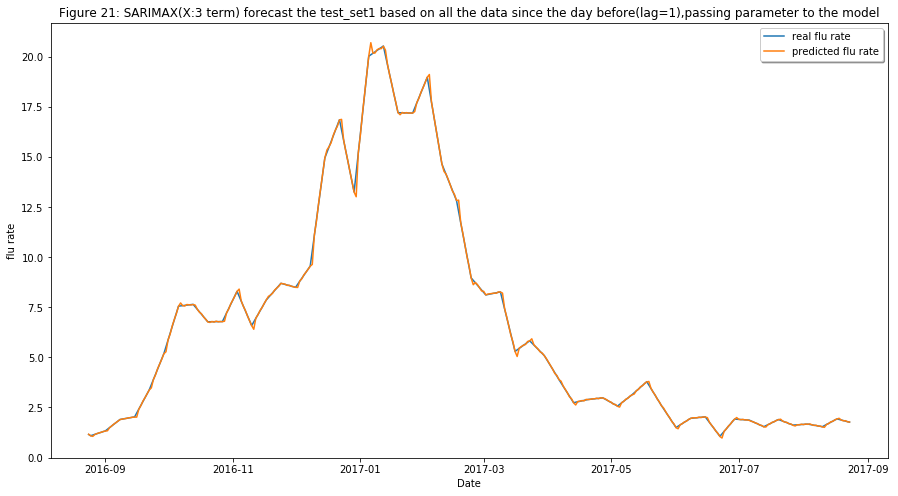

In [33]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 21: SARIMAX(X:3 term) forecast the test_set1 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [6]:
## lag=5
train1 = train1_y2.values
test = test1_y.values
test1 = test1_y[4:].values
df = X.iloc[:,0:3].copy()
df3 = train1_X2.iloc[:, 0: 3].copy()
df4 = test1_X.iloc[:,0:3].copy()

history = [x for x in train1]
predict2 = list()
count=0

for t in range(len(test1)):
    exog_train= df[0:4018+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(1,2,14),
                                      seasonal_order=(0,0,1,12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+5]
    output = model_fit.forecast(steps=5,exog=exog_test)
    yhat = output.values[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test1_y[4:].copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.0192595415754466
1


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9251694216995149
2


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.93444687106896
3


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3037697742773466
4


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3690484550085977
5


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3510940213468337
6


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3177278465494588
7


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.329861868642402
8


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3157809058394732
9


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3618854656666155
10


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.814810587083503
11


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.913501876252441
12


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.941623164570578
13


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.902712762591768
14


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9125070767658239
15


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.934514869898882
16


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.99061908642661
17


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0056434248577735
18


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0361217480693115
19


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0388752296207078
20


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.965210779319915
21


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9412368589069577
22


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9153511109735057
23


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.959340516081217
24


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.1559367240417924
25


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3629985478692817
26


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.5406222172076123
27


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.5320878014780037
28


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.605318835691539
29


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.7256810931560875
30


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.85691466577148
31


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.888136799510259
32


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.109451560915541
33


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.3402923628757275
34


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.310428991890036
35


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.332671754882116
36


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.496648500889753
37


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.628281769710095
38


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.165523187491169
39


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.445759101600164
40


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.798629910651827
41


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.809127483398833
42


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.833165516534344
43


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.104450849710657
44


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.308554610953538
45


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.574802311176833
46


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.563201063201505
47


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.688465126202574
48


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.48502874024704
49


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.384819354662091
50


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.431860255328519
51


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.444816722379699
52


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.902866110388384
53


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.760432247692791
54


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.825108443430037
55


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.673031574956794
56


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.665834948968699
57


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.63257800756276
58


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.629502887656625
59


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.808261683094978
60


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.74600141683254
61


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.8878295946810795
62


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.772417563055904
63


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.826231362104367
64


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.851712850339161
65


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.895991845386236
66


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.084362682455103
67


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.240593801116988
68


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.480461929288273
69


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.469051276988003
70


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.551035986657062
71


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.715081032894664
72


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.857518304093976
73


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.864589694634255
74


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.5671414499827625
75


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.442195965836782
76


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.169844840606244
77


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.042643162954416
78


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.898427047040559
79


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.723607999611493
80


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.735826464227688
81


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.867334961213592
82


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.120548121694348
83


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.206934782279221
84


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.430277722026666
85


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.561497535764959
86


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.759606665570946
87


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.575117317694009
88


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.628124333143418
89


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.720570387227076
90


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.592817035695402
91


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.533466850808134
92


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.631335491099671
93


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.633584730206834
94


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.572101979386185
95


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.465702099111219
96


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.555205251980725
97


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.471629050697745
98


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.496691225649418
99


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.504202127344678
100


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.507772990820063
101


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.440823644814314
102


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.49156427859543
103


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.713073822567843
104


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.700145815363799
105


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.7548075030195
106


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.886943302005115
107


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


10.012133850160104
108


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


14.152934671534206
109


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


14.7618566299946
110


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.480875251911014
111


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.687230000830882
112


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


15.920086927092735
113


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.48258839690582
114


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.90873188391296
115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.52358182945545
116


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.65683213665055
117


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.958982584491604
118


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.793588652515016
119


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.627416359548242
120


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.89170913236898
121


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.95634799584162
122


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


13.824678963414355
123


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


13.240827310308754
124


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.059699188093642
125


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.774029912094854
126


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.597441237647507
127


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.35359408947115
128


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.130111900466412
129


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.03682906395607
130


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.85260454221608
131


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.877509565384738
132


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


21.373111940472203
133


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


21.87201017664747
134


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


22.638519154522502
135


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


23.329448977744562
136


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.36711348054445
137


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.310608281872625
138


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


20.381673688603076
139


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.990234228923345
140


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.620278759536024
141


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.711454404193383
142


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.56828725105909
143


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.779927934201915
144


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.21543062479096
145


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.183810803616684
146


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.045854022279844
147


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.058849187774225
148


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.865975010157648
149


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.75027467906562
150


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.239144193621303
151


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.144713752003774
152


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.331600809686158
153


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.342448232048202
154


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.446691696335687
155


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.527650105047854
156


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.601977674116704
157


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


18.740196628666055
158


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


18.89681932693631
159


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.176737215155114
160


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.21234309406401
161


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.34372346797293
162


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.526440125166836
163


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.67602676507808
164


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


15.34299199689778
165


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


14.680387553581912
166


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


14.265699037113741
167


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.888151379088919
168


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.676968353625417
169


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.265457199211033
170


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.893776404644706
171


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.231023292572592
172


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.937052349826565
173


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.876699062185757
174


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.92791308460023
175


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


13.196990492976765
176


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.9998692340483
177


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.004407678951983
178


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.647965079541867
179


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.070977921973416
180


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.576640162162883
181


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.265778211276933
182


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.1930862423123
183


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.717198151767522
184


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.388319632569975
185


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.409544054207302
186


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.261217027525861
187


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.16376731186754
188


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.23902641950152
189


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.572776996957966
190


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.366497636466864
191


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.399077307254732
192


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.344106032589055
193


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.305315200042603
194


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.197798399786334
195


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.116693398702807
196


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.214710027712252
197


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.074117812576723
198


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.05571666175838
199


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.877381398848331
200


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.419814091856506
201


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.028501617678658
202


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.782889188181496
203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.813384504084067
204


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.377819634515226
205


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.141929729835541
206


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.888210293627658
207


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.91248131798906
208


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.957638204359559
209


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.030664625098459
210


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.336878483674158
211


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.251841078726327
212


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.382559933307039
213


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.288462382816589
214


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.1246019665320155
215


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.932841758381582
216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.724832500929544
217


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.7306447037389425
218


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.50434929474116
219


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.3965317100988806
220


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.185747749952822
221


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.9795126880726106
222


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.8388386114414836
223


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.739857466601145
224


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.878090833323237
225


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.6537283503518028
226


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.5839669589162804
227


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.0194275302972886
228


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.816255849073966
229


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.6350159253814462
230


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.4865584937619962
231


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.56558312622174
232


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3259181899723127
233


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.2450122082316226
234


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.981916007115326
235


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.9537694018164222
236


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9465867222240223
237


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.8928190334805945
238


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.054978863313598
239


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9497520696006907
240


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.987753509934756
241


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.0395387240372327
242


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.996786908775607
243


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9680064249264775
244


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.8384210379524815
245


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.903892398945313
246


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.7940270236571
247


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.8047913559555924
248


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.703364052454527
249


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5979277496760895
250


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.561130566058458
251


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.423360054816106
252


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.49867201615657
253


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3571536892882774
254


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3599871141226525
255


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.109309981703671
256


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.140669778743628
257


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.2241224411447056
258


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.1595196599771316
259


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.2631939332946853
260


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.2412137179056186
261


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3243187398550513
262


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.731631317146396
263


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.757349202774472
264


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.85764884450053
265


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.741568564788077
266


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8026523079943932
267


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7846319313272794
268


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.855657227673485
269


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.82511600559266
270


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.6047320059678296
271


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.518686135618742
272


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.310589214930251
273


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.286503697370233
274


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.1088172744331897
275


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.042605917637602
276


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7361768979813725
277


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5345775246516546
278


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4799037983394605
279


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.352507847812829
280


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4178173268340772
281


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2429893824085119
282


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.226189179313402
283


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9403806254395295
284


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9657599345149008
285


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.032192350854133
286


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9826554619255534
287


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0742781062485416
288


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.046587006224756
289


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.1210484799268228
290


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0551289051733312
291


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.0251697139194613
292


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.0296558471725823
293


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.901459061389532
294


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.928139688333423
295


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.84545265946414
296


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8701584428272413
297


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.247517424702508
298


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.0845408357387614
299


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.0024360096032687
300


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


0.8579876052016918
301


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


0.856916226878612
302


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.7001603446122611
303


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.6618626582692273
304


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8286440629889649
305


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9223086645380487
306


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.041546436041737
307


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.0434890147426503
308


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.170270716388311
309


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.1790294180684966
310


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.310791908217818
311


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.891405527767343
312


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8551278850906796
313


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8356166426662937
314


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6881399731499147
315


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.658297447458819
316


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5813276841446866
317


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5862496070239458
318


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6151308585393267
319


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.553996328932031
320


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.5605306456844794
321


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4760346339472015
322


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.5255425511098357
323


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.434882758740371
324


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4700679468942144
325


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8550500599760424
326


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.890684083911905
327


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9596598905658726
328


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.883643792153007
329


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9406754931084669
330


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.913169888721261
331


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9815035991510623
332


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6702502408632798
333


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6200921742524312
334


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.619444502359397
335


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.469626803256731
336


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4948372249738369
337


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.3858638139911486
338


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4053224986496666
339


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6701832157382563
340


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.6726272730343277
341


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7251610436468634
342


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6523667640163122
343


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7082083671681627
344


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.653185143068694
345


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.712795359238711
346


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5588233137151235
347


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5330180545461245
348


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.5587340625990607
349


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.4316011194975877
350


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4578976559243149
351


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3632585457009418
352


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3915789378739243
353


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8787772290326532
354


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9140788794342034
355


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.0204889341781413
356


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9513649158677129
357


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.01347210012528
358


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9943827477024065
359


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.0733096605242456
360


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7598053659041135
361
0.42779764691825883 0.8335136302456442 0.9890958795029838


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


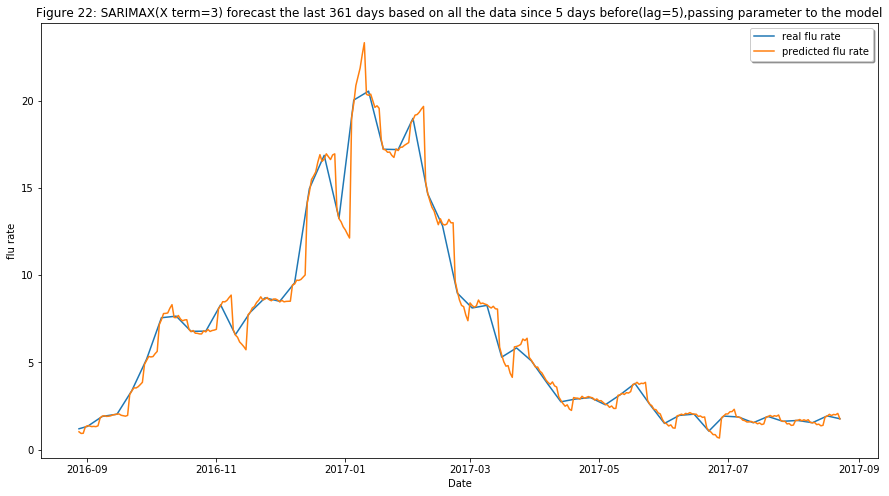

In [36]:
## lag=5
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018+4:],df.y[4018+4:],label='real flu rate')
ax.plot(date[4018+4:],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 22: SARIMAX(X term=3) forecast the last 361 days based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [7]:
## lag=10
train1 = train1_y2.values
test = test1_y.values
test1 = test1_y[9:].values
df = X.iloc[:,0:3].copy()
df3 = train1_X2.iloc[:, 0: 3].copy()
df4 = test1_X.iloc[:,0:3].copy()

history = [x for x in train1]
predict3 = list()
count=0

for t in range(len(test1)):
    exog_train= df[0:4018+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(1,2,14),
                                      seasonal_order=(0,0,1,12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+10]
    output = model_fit.forecast(steps=10,exog=exog_test)
    yhat = output.values[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test1_y[9:].copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


0.8903651016552896
1


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


0.7513327612408265
2


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.7891470230274805
3


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.3560559025510466
4


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4100866170042712
5


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.3756597803069657
6


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.325801098041271
7


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.3179035361968077
8


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.2558022004903442
9


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2928087831055142
10


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9373081980676994
11


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9866612261452645
12


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.019461674196026
13


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9473569807375983
14


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9322337641432978
15


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9170593891927703
16


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9500634393589797
17


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9242009513582659
18


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9344645429419307
19


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9453442507445267
20


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8456165957698405
21


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8317500494719519
22


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7954390283290318
23


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.8702007259425493
24


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.672708001367504
25


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.8025782451630725
26


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.013022783459948
27


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.9237473437068324
28


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.9107109180024153
29


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.943330442972991
30


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.976802670508757
31


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.384625901805949
32


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.439888390967985
33


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.747381096672125
34


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.625918920190775
35


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.576290433123602
36


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.711071674484193
37


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.756825106175979
38


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.954784937283124
39


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.046383629486758
40


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.49730401595393
41


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.391268863632627
42


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.281423825292917
43


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.508029526168594
44


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.579052695602783
45


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.286315577180946
46


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.232755978729837
47


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.460416943879715
48


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.159183133309899
49


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.130744594924323
50


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.296088343844726
51


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.38175930948405
52


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.643054746624057
53


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.589438873645122
54


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.709810356327069
55


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.471855435691239
56


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.538245465449507
57


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.523587968852508
58


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.566113916343097
59


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.884084917136118
60


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.8122450236210055
61


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.0257213554542375
62


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.818673021472259
63


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.894697463503162
64


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.897814672578244
65


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.927661909003764
66


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.691522440672307
67


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.725043412779787
68


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.03179934247618
69


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.922902864721843
70


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.929334311156909
71


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.024798583700912
72


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.06843093688626
73


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.931485014888978
74


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.6694690804080485
75


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.609083274813646
76


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.303572548128023
77


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.376224457566103
78


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.4022669751071115
79


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5.408758265569722
80


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.675059484348255
81


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.774787193604922
82


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.045640104564784
83


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.0403424313338
84


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.135203376519723
85


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.059501333216163
86


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.073945596301327
87


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.558174790172536
88


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.456050536140966
89


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.632836768547174
90


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.437586077069154
91


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.412972218611676
92


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.608783897713007
93


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.636467092103718
94


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.57579296576764
95


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.457548809935698
96


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.608592714904184
97


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.45432734131823
98


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.509814339085308
99


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.519875495916837
100


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.516655111445038
101


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


9.926109679304624
102


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.8684222315978
103


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.173664732599898
104


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


10.071608256155793
105


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.063077610136876
106


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.147234185825573
107


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.206996667785576
108


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.3269707448737
109


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.50962762715239
110


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.386788250312115
111


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.40308736258495
112


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.29290845022354
113


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.64651718328756
114


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.697584353934133
115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.625843032363786
116


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.471124104196374
117


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.962933811535173
118


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.67397045276421
119


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.52544819167875
120


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.016161340287997
121


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.11962772449441
122


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.444622170483747
123


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.103070512271588
124


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


11.98106879082875
125


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


11.667638184376928
126


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


11.76905043932457
127


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


11.752172979929984
128


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.790598517400145
129


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


22.530949423636095
130


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


22.99706142937903
131


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


24.15210364924683
132


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.417215194683127
133


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.32956561605154
134


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


24.60391706377327
135


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.650871908512606
136


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.344845624246126
137


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.99480259694977
138


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.28658984801686
139


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.803885266136373
140


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.683717304042663
141


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.2521895255062
142


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.401022261325547
143


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.057755142676175
144


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.80937573747799
145


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.814312169757567
146


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16.625891624712526
147


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.817861119489415
148


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.67297756525326
149


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.67203830062051
150


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.584062513281797
151


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.520176816642838
152


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.771283245061234
153


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.715499827115938
154


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


17.80351981477116
155


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.83366045799432
156


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.858048279049036
157


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.49493216235488
158


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.491103428038652
159


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.849777614319596
160


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19.79537131427753
161


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.868761365849725
162


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.993950308712993
163


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


20.047626798986055
164


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


13.385375429940085
165


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.936292736520533
166


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.550542594189103
167


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


12.214657797083117
168


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.418102307072765
169


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.311079909408228
170


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.339236053700628
171


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


13.353613464394723
172


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.296158903924338
173


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


13.173415556432875
174


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.21713769497091
175


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.538069569841536
176


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.122434159612288
177


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.093559916414467
178


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.993428666591525
179


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.5898200874909705
180


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.061623754067923
181


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.824813193444229
182


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.126548115965748
183


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.807500439199033
184


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.829025357236091
185


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.778818369357731
186


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.7446127198756
187


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.560764931009153
188


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.640413560390165
189


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.99599818757361
190


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.503497844326601
191


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.4663297863686
192


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.272927897148247
193


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.112941049207137
194


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.007826868745987
195


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.930844617113762
196


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8.118723022438669
197


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


7.921157526069643
198


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.976416876517256
199


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.731547631658855
200


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.39937593011094
201


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.965669495979421
202


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7572948958613255
203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.07648832842283
204


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.666500393211965
205


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.672800465044902
206


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.578340709031425
207


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.578495493065536
208


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.587384658096077
209


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.626308711011273
210


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


6.883918210239118
211


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.51057081861917
212


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.53246763875032
213


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.694561394218171
214


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.4430761094544495
215


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.265741314147871
216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.057625194861275
217


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.2412327534807135
218


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.048954627550449
219


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


4.1053063990735765
220


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.9487004805556536
221


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.7979958699669627
222


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.6309117886462188
223


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.5206966632114747
224


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.762857516811714
225


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.4246129336262934
226


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3978260607406336
227


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.590827311804287
228


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.4012144487759564
229


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.204633613141899
230


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.0522022315066035
231


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.2697362795712275
232


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9728086722403277
233


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9914449720881122
234


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.1925311384710375
235


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.10827409191023
236


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.097961189988541
237


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.0002741181348322
238


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.1848500710105596
239


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.927231974766356
240


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9391287030622557
241


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9516513722539597
242


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.8204479491887597
243


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.81865189806606
244


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.643814296816875
245


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.7800944291074074
246


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.6147560518662347
247


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.6759161670824025
248


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.535680052715823
249


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.4078376184977497
250


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.3900563285603553
251


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.202454955299782
252


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3590990182840965
253


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.1540188346031823
254


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.208746423320621
255


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3617401853085234
256


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.315980741525953
257


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.4347819871872374
258


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3002365330450907
259


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3994931049951864
260


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.2702704515375416
261


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3262294234301097
262


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8580568965743045
263


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7699432437628966
264


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.933239518475938
265


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7349324880335057
266


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8191712029850584
267


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3.7487513211394834
268


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8273910983742354
269


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.236446543828556
270


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2.037400114640813
271


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.9930295075223767
272


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7405871239135486
273


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8594343758640945
274


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.7145898184709734
275


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7790054525531873
276


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.442452816245893
277


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3029986314280704
278


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2604476744403572
279


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.0943003609525106
280


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2449514589237813
281


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.0024192592858856
282


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1.0452522049760657
283


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.161222063490179
284


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.125260635921652
285


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.218309443957228
286


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.113830205915075
287


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.193419848496987
288


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0609271437568184
289


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.1091851867099765
290


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.930676690485417
291


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.835674183825259
292


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8756765700312783
293


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.696419920377677
294


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7805881585235075
295


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6716676663288845
296


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.748338912416193
297


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.8279233843144659
298


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.6992769245600949
299


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.6334598647833027
300


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.4621586971535784
301


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.5546509670257156
302


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.38913947139515787
303


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.4424186991338442
304


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.2738196236953585
305


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.306996447682809
306


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.4454097217867616
307


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.386751720884695
308


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.458795316153029
309


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.320833257040383
310


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.384136951876251
311


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6163269355537597
312


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.516326519933472
313


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5362674026599057
314


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3475251819079757
315


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3909461922659248
316


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3391177471016087
317


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4285872213789685
318


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5269791836139988
319


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.486931628259001
320


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5073310410470617
321


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3800006663045044
322


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4683252653155747
323


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3134720321833586
324


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.376469893940711
325


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.95074257425619
326


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9444227116948847
327


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0465463874834646
328


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.912464259797366
329


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.981713583440512
330


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8852842245722972
331


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9561218514861636
332


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4377009931382105
333


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3800324800111479
334


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.410278905451856
335


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2048385120334786
336


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3108453450197468
337


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.182389282556784
338


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2707395126831764
339


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7052575096911375
340


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7063237350135405
341


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7828660514130983
342


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6568620276977448
343


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.730682144890113
344


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6037341912670713
345


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6715175220308944
346


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4008005090855966
347


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3628873415764104
348


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4258175568575253
349


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2418196155987093
350


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.331106745207967
351


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2038079203572178
352


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2828775060073612
353


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0332062506603847
354


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0338381997579082
355
2.178829097289722
356
1.2338922659462872 1.9243389075955617 0.9442159435418076


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


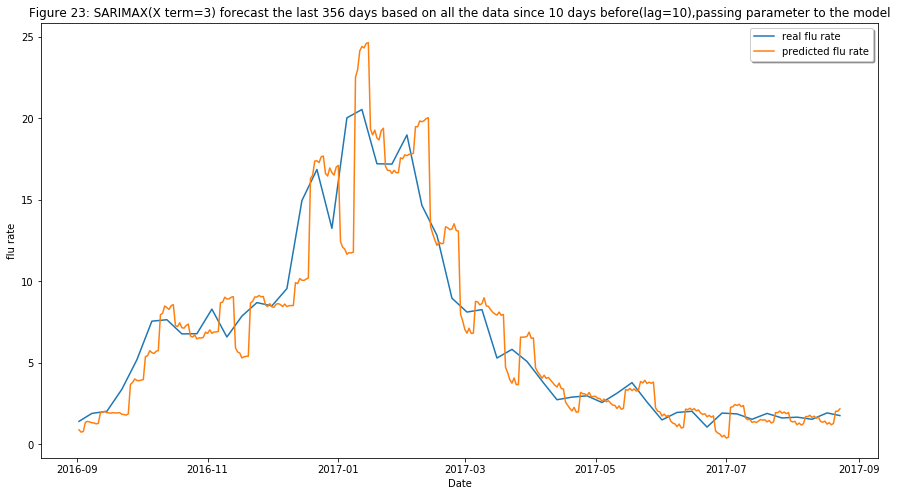

In [38]:
# visualize lag=10
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018+9:],df.y[4018+9:],label='real flu rate')
ax.plot(date[4018+9:],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 23: SARIMAX(X term=3) forecast the last 356 days based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [8]:
## lag=14
train1 = train1_y2.values
test = test1_y.values
test1 = test1_y[13:].values
df = X.iloc[:,0:3].copy()
df3 = train1_X2.iloc[:, 0: 3].copy()
df4 = test1_X.iloc[:,0:3].copy()

history = [x for x in train1]
predict4 = list()
count=0

for t in range(len(test1)):
    exog_train= df[0:4018+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(1,2,14),
                                      seasonal_order=(0,0,1,12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+14]
    output = model_fit.forecast(steps=14,exog=exog_test)
    yhat = output.values[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test1_y[13:].copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.7838486478490698
1


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.6268829192184726
2


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.6810967205028611
3


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3424168390901914
4


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.372346587594349
5


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2957025578575572
6


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2083727894795304
7


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2055520358087364
8


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1438708995440137
9


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1956205317834148
10


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9486206198283267
11


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9647719589451258
12


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9554900613098405
13


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8391338479093613
14


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8259972280915209
15


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.816968723364374
16


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8700625936290347
17


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.833028224842442
18


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8497814830387385
19


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8622832295523315
20


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7459074611847238
21


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.737010741369665
22


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6981505966345243
23


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.797502281754722
24


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.891298391842404
25


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.922755786016618
26


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.05597160122309
27


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8369560021561226
28


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8311369548261687
29


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8757851837814066
30


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.9243402863770527
31


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.565087235023043
32


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.528993076438854
33


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.799679171133229
34


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.570791184209781
35


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.511960952675236
36


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.679030568714657
37


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.745657832883851
38


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.295693340359438
39


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.246506916916132
40


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.637281973849174
41


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.372783552138218
42


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.24401797268228
43


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.516439752897004
44


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.612147785345984
45


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.090345545038115
46


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.106359798477365
47


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.44194288094599
48


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.147360527517554
49


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.119327167149287
50


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.3093621600479945
51


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.418330526714568
52


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.540860852898147
53


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.513898815437036
54


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.698155711099998
55


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.452527909897524
56


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.539530532864572
57


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.521489435913698
58


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.573982402734747
59


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.936160397133513
60


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.8251495730558895
61


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.059667749964303
62


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.793169123161574
63


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.893052699520303
64


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.891513046859549
65


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.935300790303741
66


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.981706298474936
67


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.895943793899445
68


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.155425459590017
69


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.91627740434362
70


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.928182435489243
71


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.046363716381942
72


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.102395826560992
73


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.4387810217416614
74


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.340275587865834
75


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.456291288745345
76


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.2782726249154885
77


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.37486949810241
78


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.4014593747515525
79


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.408213335347483
80


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.204907529043334
81


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.098631804950898
82


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.22834725267558
83


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.03248468315037
84


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.154853220453338
85


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.05960765126177
86


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.088415480689704
87


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.484288483336714
88


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.40431438626355
89


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.643249215857702
90


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.43509284772812
91


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.414741429562252
92


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.64801309055743
93


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.679951286634086
94


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.597413314076856
95


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.45482531755221
96


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.63666132497798
97


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.461670903778339
98


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.53608767750322
99


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.54139521341897
100


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.541810419924278
101


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.177450587436436
102


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.014485747455135
103


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.297215451194973
104


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.089144434618504
105


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.085842161884512
106


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.185401058530145
107


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.257902393373016
108


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.382088749363778
109


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.173171133142187
110


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.844022235590725
111


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.48677357380639
112


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.354357955622312
113


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.773681006109975
114


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.83955194213983
115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.583715299844354
116


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.465340498538986
117


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.10160587691573
118


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.79821667980574
119


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.615142819155317
120


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.187153038609125
121


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.306651608442948
122


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.840253582950252
123


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.731652822376276
124


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.863563212366328
125


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.766195112888541
126


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.887841492362082
127


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.855398832663132
128


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.892802641404172
129


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.390123244132976
130


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.2050612303031
131


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.923727577035173
132


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.588034367640525
133


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.479523763300847
134


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.79195367809144
135


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.85847844726538
136


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.672172622748516
137


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.611622785413665
138


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.264746685083164
139


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.972830643916733
140


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.82113820043068
141


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.479955154564603
142


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.64327425468382
143


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.888435036258095
144


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.72199050310238
145


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.869081291558135
146


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.78572020239418
147


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.01170068870994
148


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.819769194156333
149


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.809583148021996
150


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.86273773136899
151


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.727221345550095
152


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.973195203986183
153


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.852254915465732
154


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.9536200561978
155


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.974853552049463
156


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.000287480443973
157


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.89806906546932
158


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.77844829909255
159


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.104813360834275
160


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.93602471559783
161


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.018522379702155
162


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.15608853680917
163


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.21803879156123
164


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.443467870946485
165


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.365301261520765
166


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.30881219247014
167


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.30674418278583
168


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.550983686081905
169


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.4072103166732
170


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.427635266437962
171


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.595389318649817
172


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.460055858939272
173


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.264888280837814
174


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.279099354804835
175


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.667131997915439
176


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.160940996636842
177


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.128413026330424
178


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.1842476789047165
179


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.076850798124989
180


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.7694106650379755
181


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.8064031310446165
182


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.178094730980683
183


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.7930535747508545
184


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.813521221111956
185


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.07879894956457
186


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.919283133877851
187


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.59475453732521
188


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.603776856246071
189


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.04232982003505
190


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.453313671177638
191


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.418553951400941
192


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.195791635404047
193


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.047754912974357
194


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.947051891925589
195


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.881680872377486
196


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.115754179002419
197


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.882705924196403
198


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.952894428506609
199


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.168096509427702
200


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.011587851783175
201


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.702857906952153
202


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.6705028876446577
203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.068392546637439
204


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.5794525096697116
205


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.590703231834006
206


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.975988639618179
207


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.797778839067612
208


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.647302893078272
209


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.543582701833278
210


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.865152435664007
211


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.421547506355187
212


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.463291472900615
213


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.324154283820333
214


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.171471074788424
215


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.084291855694488
216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.956098505184373
217


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.189566479570464
218


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.9660776269893745
219


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.038524386113455
220


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.850916738686875
221


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.696024646121304
222


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.5152938498655804
223


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.413489710978733
224


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.718769011625222
225


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3188598269945735
226


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.2974068243419845
227


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3607899310373037
228


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.2115489971657967
229


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0391387161942296
230


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9255401543094601
231


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.2004304621545123
232


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8521665840521302
233


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8823168614106023
234


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.2832404553199974
235


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.117893449733414
236


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.0421450166736848
237


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.8751892362662868
238


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.1099733486219074
239


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.8093735133683895
240


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.835814147178448
241


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.8527171131343136
242


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.7125187951505985
243


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.716488695151963
244


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5198320709073947
245


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.6962007060180597
246


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.504437188251817
247


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5879307848352773
248


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.4225080896289084
249


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.2894668589670695
250


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.2809074058426027
251


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.078144156024816
252


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.279427415330569
253


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.039201373687964
254


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.1164886284186903
255


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.456305951605808
256


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.3334255157638455
257


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.407277578587172
258


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.187081722377937
259


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.31862092133244
260


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.169476070970717
261


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.2475328213231918
262


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8651258602887855
263


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7310005589960733
264


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8953188442779316
265


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.6310070919718815
266


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7431026722354654
267


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.662875840625218
268


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.767554674976383
269


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9111943669316822
270


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7863688799329225
271


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8316379981694655
272


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6299931494324218
273


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7836752762437362
274


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6148535700216768
275


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6989171990940382
276


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.304268477503844
277


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1647044580224426
278


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.139968318926452
279


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9741947156746906
280


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1663453775394739
281


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.8832253889831055
282


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9436522765346524
283


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.242951975323174
284


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.1342036340848227
285


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.1796650523796144
286


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9968462660115336
287


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.103259815965953
288


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9514918615868795
289


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.019597535202106
290


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.813267374051913
291


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7176433129620734
292


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7790746290956723
293


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5814693070853525
294


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.690937242762789
295


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5687379046754029
296


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6687171951151243
297


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.5932826986836051
298


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.5080443916564583
299


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.4850428642454336
300


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.34357498970779055
301


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.46561332848007686
302


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.27490998885920964
303


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.345427730360188
304


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.478119961397066
305


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.396974958228191
306


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.451256767475569
307


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.2805761554278057
308


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3738280687005706
309


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.2159982121631256
310


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3034374586567226
311


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4099592041824476
312


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3500666219472217
313


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.417121890887461
314


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2412690415082694
315


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2994082773288578
316


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.243914886624436
317


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3602055358642364
318


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4691201332564316
319


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.415043756840586
320


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4286814922087625
321


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2779175939959635
322


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3901256901495098
323


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2124630594926922
324


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.298763366874929
325


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9641093537660153
326


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.922670687148407
327


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.004850313836919
328


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8126930820943357
329


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9018870450488154
330


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7921200589673423
331


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.886959066088481
332


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2824522387009205
333


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.251181641882876
334


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3132360917920896
335


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1009179649806617
336


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2336011099453212
337


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.085350028711602
338


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2034023284574815
339


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7036466540124873
340


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6788709624881564
341


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.735904382267625
342


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5609719319633284
343


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6577922870307078
344


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5093053207310216
345


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6020365146467832
346


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2853937917736387
347


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2611272444095292
348


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3473660727597727
349


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1449974545143602
350


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2572182033400028
351
1.107632254009078
352
1.737702392756204 2.5387956572466677 0.905008482554758


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


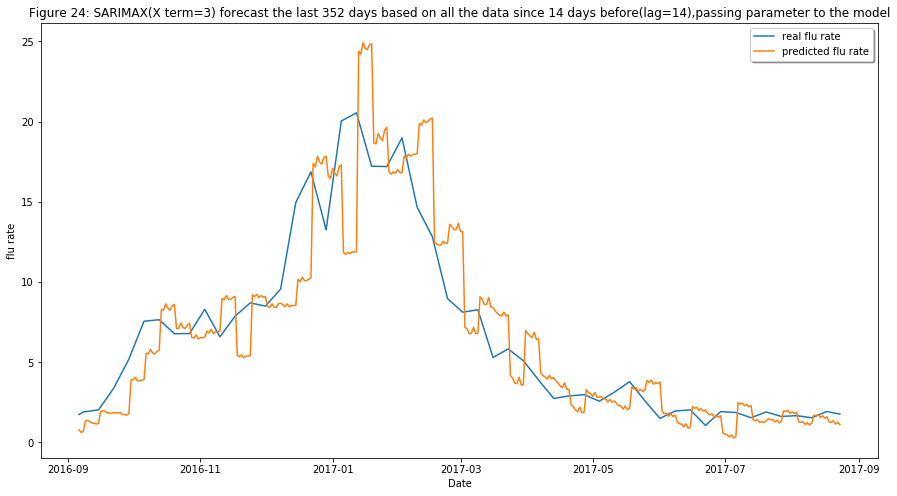

In [40]:
# visualize lag=14
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018+13:],df.y[4018+13:],label='real flu rate')
ax.plot(date[4018+13:],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 24: SARIMAX(X term=3) forecast the last 352 days based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [9]:
## lag=28
train1 = train1_y2.values
test = test1_y.values
test1 = test1_y[27:].values
df = X.iloc[:,0:3].copy()
df3 = train1_X2.iloc[:, 0: 3].copy()
df4 = test1_X.iloc[:,0:3].copy()

history = [x for x in train1]
predict5 = list()
count=0

for t in range(len(test1)):
    exog_train= df[0:4018+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(1,2,14),
                                      seasonal_order=(0,0,1,12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+28]
    output = model_fit.forecast(steps=28,exog=exog_test)
    yhat = output.values[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

corr_y = test1_y[27:].copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.3915672277906577
1


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.22989191415103788
2


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.2883719352515945
3


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9734743458981112
4


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.0089398274442045
5


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9325059321710321
6


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.8453129585487413
7


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.8442796593087493
8


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.7790211286071836
9


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.8380268551102726
10


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6178069959941883
11


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.640175838976101
12


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6375723375925688
13


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.516464856676479
14


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.508464679000399
15


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5025773382542829
16


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5555880477401762
17


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5236496349425397
18


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.538724509856129
19


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.550150203370143
20


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4342230513650445
21


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4284956713719335
22


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3915212662293617
23


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4921808273787673
24


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.669127531695953
25


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7044820076729357
26


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.846200037892266
27


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.6280421957781215
28


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.625159789370637
29


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.6739350886454654
30


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.730270250507631
31


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.430784266187166
32


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.404840980828225
33


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.695585980477856
34


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.462578074177971
35


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.407863711248372
36


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.580825716523411
37


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.654330024244542
38


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.305380780849234
39


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.262334235123323
40


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.681965627172971
41


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.411079864596926
42


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.28677202147581
43


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.573203552513258
44


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.67514108607344
45


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.100802251870468
46


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.114399087295989
47


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.465421512535602
48


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.15763535469792
49


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.129309544261681
50


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.324608192952058
51


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.438121281846471
52


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.525486875603389
53


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.494197638145024
54


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.681374452184104
55


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.426350958231132
56


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.510142853404143
57


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.492824533585165
58


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.546840129845083
59


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.9229584498442405
60


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.806510880694608
61


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.0504480479704466
62


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.773559625520238
63


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.877846892625633
64


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.875987296621556
65


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.919834816724456
66


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.046009452992637
67


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.967954698433621
68


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.239022276273655
69


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.993229999870726
70


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.012990850619646
71


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.135187486712596
72


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.196996828118582
73


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.3916188815321044
74


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.287435473989412
75


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.400245320083565
76


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.210667425821283
77


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.305136463497361
78


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.3344925716056375
79


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5.334733776814961
80


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.273183692683077
81


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.166264929258704
82


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.30689173523956
83


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.109664692952844
84


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.238167759506709
85


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.14436455853345
86


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.177747305574403
87


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.554847220939653
88


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.470736251855994
89


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.724353868092873
90


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.509946891358055
91


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.489071920836789
92


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.7269366438833
93


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.761567061450407
94


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.67776112690948
95


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.523886861194972
96


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.714237606631768
97


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.530879241717145
98


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.608741818730094
99


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.614496776220117
100


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.613479844296986
101


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.313254665390215
102


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.15154412101724
103


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.444522034475433
104


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.2326274360246
105


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.231255626434184
106


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.336967031791492
107


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10.413805408162606
108


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.815686845985606
109


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.617779513361675
110


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.328857097369273
111


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.97513439631934
112


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.852851177021176
113


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.294962161643106
114


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.371723592074677
115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.071238998618487
116


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16.95249879580116
117


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.61864693672091
118


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.307804817568332
119


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.123499406724633
120


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.71279348264995
121


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.83535214660867
122


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.15518087233292
123


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.030372960537996
124


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.15407419663452
125


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.038224135552543
126


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.153603932821202
127


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.110316042175043
128


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.142335581115562
129


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25.121684597149333
130


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


24.94660000475432
131


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25.71401356702335
132


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25.386023288978397
133


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25.291326001678584
134


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25.629121270372192
135


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25.70966779966799
136


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.295722457686587
137


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.231011788550024
138


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.908260026718157
139


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.604822188940954
140


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


19.443668855041107
141


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.120277707607414
142


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.28395195341294
143


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.412389142865162
144


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.226835159080732
145


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.365523383239037
146


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.26631541987626
147


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.4864619249051
148


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.28263516289279
149


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17.271026099880796
150


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.358778326743586
151


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.216110119719684
152


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.468070011559405
153


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.341476853008515
154


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.443845096340958
155


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.464184113983958
156


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18.48846701444029
157


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.460084957090174
158


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.34090368317531
159


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.682995387598694
160


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.5115880321542
161


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.601696949290723
162


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.74407699560539
163


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20.809246693550644
164


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.733046137718292
165


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.636299546212635
166


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.561061210706288
167


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.540454059354882
168


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.778158142402571
169


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.621616847451968
170


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


12.634928499508353
171


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.837044788609784
172


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.689533606032878
173


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.477740023840433
174


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.485600579828741
175


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.881441327904014
176


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.356072433136779
177


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


13.322669729437834
178


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.147953024488751
179


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.022516661583082
180


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.69000358860405
181


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.7176857806865655
182


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.088539135937084
183


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.680055628268331
184


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.693659315236148
185


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


9.04086024043301
186


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.872541256769306
187


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.534071051584332
188


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.538667421422042
189


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.991838998325587
190


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.381911206980787
191


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.346621342310476
192


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.118223465297971
193


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.965757344284526
194


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.861521083628486
195


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.793062033062278
196


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


8.038975219050268
197


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.793242775227939
198


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7.8686762684685
199


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.935698241802053
200


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7629879605755203
201


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.4342363180819926
202


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.39294492116344
203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7954266852984184
204


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.284157702480596
205


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.2919685923919553
206


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.803447898119637
207


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.621915811080186
208


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.466922660353849
209


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.362685257651341
210


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.698943444276226
211


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.244553139516143
212


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6.2869874304375
213


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


4.070583217155216
214


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.9128695473990995
215


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.8185056141592675
216


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.683289681188406
217


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.925578532745494
218


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.691573797279747
219


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.7617666551166113
220


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.5666818669205407
221


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.4037559503521884
222


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.213542174934902
223


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.1056262327154336
224


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.4196269305702933
225


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.004757034434984
226


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9815602983033584
227


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0087942653086484
228


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8517815289235784
229


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6709728887460729
230


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5501449778790886
231


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8343005339491827
232


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4706375650208667
233


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.502763488689327
234


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.955801258795961
235


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.787670090040402
236


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.7103818839643115
237


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5387179966093294
238


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.7844688336976593
239


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.474476518220353
240


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5045530429019016
241


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.5221009256325946
242


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.37911993754464
243


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3848919669447133
244


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.182962518887933
245


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.3670478734391094
246


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.1690445457058174
247


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.255891177184172
248


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0844300237079594
249


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9458941699742263
250


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.93903381856021
251


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7275002855345059
252


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9367247594892403
253


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6874904001524933
254


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.769133988439556
255


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.1630963174635522
256


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.037645384771462
257


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.118253128822383
258


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.891598106573882
259


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.031865340640772
260


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.8789594196200747
261


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.9627039891176152
262


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.6071878758338323
263


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.470473017728491
264


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.643846896703687
265


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.374280319781956
266


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.4932849315654497
267


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.412091925577235
268


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3.5209388293040367
269


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5931721408096549
270


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4623889674243997
271


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5061955338616306
272


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2952562743214422
273


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4518621875795943
274


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.275104193251436
275


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.360662891898062
276


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9496201465395564
277


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.8033703962063423
278


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.7764334873607778
279


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.6015417318142525
280


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.7984426107490767
281


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.5047342345994468
282


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.5688296895982408
283


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9180158041819495
284


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8079980981756734
285


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.8578418296853674
286


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6726985643776107
287


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7854661566435563
288


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6306993859302354
289


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7025938845224482
290


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4906175885533943
291


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3939396024007784
292


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.4576403371207556
293


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.2549383786192172
294


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3706355222787117
295


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.243144764353649
296


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.3469503647117547
297


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.23175111953364633
298


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.14251178851495996
299


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.1156835711357741
300


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-0.03209725349858614
301


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.09145845845596931
302


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-0.10702899574462511
303


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-0.031932412554457106
304


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.1824431017938615
305


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.1023789225035316
306


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.161087933950503
307


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9908749001369195
308


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0911508723760943
309


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.9317021635425082
310


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2.0251293101339596
311


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.099904694724331
312


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.038957010643343
313


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.110640537914241
314


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9273102549349986
315


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9906495338924366
316


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9323097422542773
317


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.0521783780975518
318


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1658604184477892
319


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.1113694756064152
320


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.12628411895349
321


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.967602545188631
322


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.0848319870059748
323


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9008895330266183
324


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9930516097436352
325


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6830331682905049
326


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6440511992656486
327


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.7300879112412588
328


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5345980259630612
329


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6299001806395357
330


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.5167879783315705
331


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.6160893731941357
332


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9895590027076403
333


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9579288131542779
334


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1.022895517154985
335


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.803167379708393
336


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0.9422538056530378
337
0.786379195320507
338
2.7211312383196433 3.845149007228335 0.7961529484612999


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


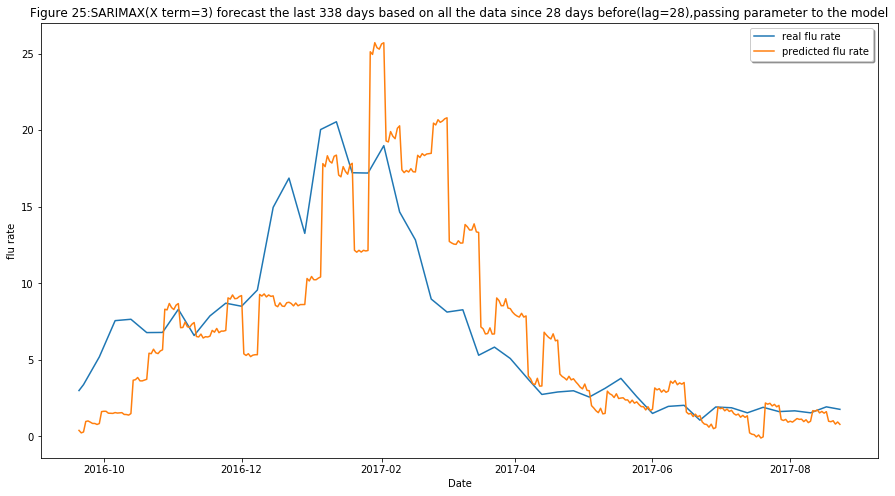

In [42]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018+27:],df.y[4018+27:],label='real flu rate')
ax.plot(date[4018+27:],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 25:SARIMAX(X term=3) forecast the last 338 days based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [16]:
model = sm.tsa.SARIMAX(train1_y2.values, order=(1,1,14),seasonal_order=(1,0,1,7),enforce_stationarity=False,
                              enforce_invertibility=False)
model_fit = model.fit()
model_fit.summary()

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4018
Model:             SARIMAX(1, 1, 14)x(1, 0, 1, 7)   Log Likelihood               -1339.072
Date:                            Sun, 15 Jul 2018   AIC                           2714.144
Time:                                    07:23:08   BIC                           2827.414
Sample:                                         0   HQIC                          2754.297
                                           - 4018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9866      0.056     17.768      0.000       0.878       1.095
ma.L1          0.0105      0.143      0.073      0.942      -0.269       0.290
ma.L2          0.0156      0.250      0.062      0.950      -0.474       0.505
ma.L3          0.0105      0.151      0.070      0.945      -0.286       0.307
ma.L4          0.0103      0.156      0.066      0.947      -0.296       0.317
ma.L5          0.0140      0.258      0.054      0.957      -0.491       0.519
ma.L6          0.0085      0.123      0.069      0.945      -0.232       0.249
ma.L7         -0.4705      0.280     -1.681      0.093      -1.019       0.078
ma.L8          0.0036      0.114      0.031      0.975      -0.221       0.228
ma.L9          0.0073      0.186      0.039      0.969      -0.357       0.372
ma.L10         0.0054      0.129      0.042      0.967      -0.248       0.258
ma.L11         0.0061      0.142      0.043      0.966      -0.273       0.285
ma.L12         0.0085      0.181      0.047      0.963      -0.346       0.363
ma.L13         0.0058      0.110      0.053      0.958      -0.209       0.220
ma.L14        -0.5051      0.144     -3.512      0.000      -0.787      -0.223
ar.S.L7        0.7460      0.006    120.921      0.000       0.734       0.758
ma.S.L7       -1.0035      0.045    -22.322      0.000      -1.092      -0.915
sigma2         0.1102      0.031      3.578      0.000       0.050       0.171
===================================================================================
Ljung-Box (Q):                       31.29   Jarque-Bera (JB):          53003555.61
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            10.33
Prob(H) (two-sided):                  0.00   Kurtosis:                       566.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""